# Image Caption Generator using ResNet and Transformer Decoder Model. It can be divided into 2 steps :
## **Step 1** : Create features for Images Using Resnet
## **Step 2** : Train Transformer Decoder Model which predicts next word given a sequence of tokens and Image Features from Step1

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from itertools import product
import math
import pickle
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pd.set_option('display.max_colwidth', None)

C:\Users\sapat\AppData\Roaming\Python\Python312\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cuda


## Read Data.

In [ ]:
df = pd.read_csv(r".\flickr30k_images\results.csv", sep='|')
print(len(df))
display(df.head(3))

158915


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their hands while hanging out in the yard .
1,1000092795.jpg,1,"Two young , White males are outside near many bushes ."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .


## Preprocessing step -> Remove Single Character and non alpha Words. Add tokens. 

In [3]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
df['cleaned_caption'] = df[' comment'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in str(caption).split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [5]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

74


In [6]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

## Create vocab and map tokens to ID.

In [7]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [8]:
print(len(word_dict))
print(word_dict[:5])

17893
['<pad>', '<start>', '<end>', 'in', 'the']


In [9]:
vocab_size = len(word_dict)
print(vocab_size)

17893


In [10]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

17893 17893


In [11]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

## Custom Train and Valid Split. 7000 images. 75-25 split

In [12]:
df = df.sort_values(by = 'image_name')[:35000]
train = df.iloc[:int(0.75*len(df))]
valid = df.iloc[int(0.75*len(df)):]

In [13]:
print(len(train), train['image_name'].nunique())
print(len(valid), valid['image_name'].nunique())

26250 5250
8750 1750


## Extract features from Images Using Resnet

In [14]:
train_samples = len(train)
print(train_samples)

26250


In [15]:
unq_train_imgs = train[['image_name']].drop_duplicates()
unq_valid_imgs = valid[['image_name']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

5250 1750


In [ ]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image_name']
        img_loc = './flickr30k_images/flickr30k_images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [17]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [18]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [19]:
resnet50 = torchvision.models.resnet50(pretrained=True).to(device)
resnet50.eval()
list(resnet50._modules)

C:\Users\sapat\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sapat\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [20]:
resNet50Layer4 = resnet50._modules.get('layer4').to(device)

In [21]:
def get_vector(t_img):
    
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 2048, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = resNet50Layer4.register_forward_hook(copy_data)
    resnet50(t_img)
    
    h.remove()
    return my_embedding

In [24]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    
    extract_imgFtr_ResNet_train[image_name[0]] = embdg
    

  0%|          | 0/5250 [00:00<?, ?it/s]

In [25]:
a_file = open("./EncodedImageTrainResNet7k.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [26]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/1750 [00:00<?, ?it/s]

In [27]:
a_file = open("./EncodedImageTestResNet7k.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

## Create DataLoader to load the data into Transformer Model.
## FlickerDataSetResnet will return 1 timestep left shifted caption sequence which model will predict and store image features from ResNet.

In [22]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image_name']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [23]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet7k.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [24]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageTestResNet7k.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

## Transformer Decoder Model

### Position Embedding

In [25]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [26]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


##  Train the Model

In [27]:
EPOCH = 20

In [28]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 2048).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float64('Inf')

c:\Users\sapat\anaconda3\envs\image_ccap\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [29]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel1')
        min_val_loss = total_epoch_valid_loss
  
    scheduler.step(total_epoch_valid_loss.item())


  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\sapat\anaconda3\envs\image_ccap\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 140.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 813.75 MiB is free. Of the allocated memory 4.68 GiB is allocated by PyTorch, and 382.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [82]:
# Define hyperparameter ranges
n_heads = [8, 16]
n_decoder_layers = [2, 4]
embedding_sizes = [2048]
learning_rates = [1e-5, 5e-5]
batch_sizes = [16, 32]

# Initialize variables to track the best configuration
best_hyperparams = None
best_val_loss = np.float64('Inf')

# Grid Search
for n_head, n_decoder_layer, embedding_size, lr, batch_size in product(n_heads, n_decoder_layers, embedding_sizes, learning_rates, batch_sizes):
    print(f"Testing configuration: n_head={n_head}, n_decoder_layer={n_decoder_layer}, embedding_size={embedding_size}, lr={lr}, batch_size={batch_size}")

    # Create dataloaders with the new batch size
    train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
    valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, scheduler, and loss function
    ictModel = ImageCaptionModel(n_head, n_decoder_layer, vocab_size, embedding_size).to(device)
    optimizer = torch.optim.Adam(ictModel.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    
    min_val_loss = np.float64('Inf')
    
    # Training Loop
    for epoch in tqdm(range(EPOCH)):
        total_epoch_train_loss = 0
        total_epoch_valid_loss = 0
        total_train_words = 0
        total_valid_words = 0
        ictModel.train()

        # Train Loop
        for caption_seq, target_seq, image_embed in train_dataloader_resnet:
            optimizer.zero_grad()

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output, target_seq)
            loss_masked = torch.mul(loss, padding_mask)

            final_batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)
            final_batch_loss.backward()
            optimizer.step()

            total_epoch_train_loss += torch.sum(loss_masked).detach().item()
            total_train_words += torch.sum(padding_mask)

        total_epoch_train_loss = total_epoch_train_loss / total_train_words

        # Eval Loop
        ictModel.eval()
        with torch.no_grad():
            for caption_seq, target_seq, image_embed in valid_dataloader_resnet:
                image_embed = image_embed.squeeze(1).to(device)
                caption_seq = caption_seq.to(device)
                target_seq = target_seq.to(device)

                output, padding_mask = ictModel.forward(image_embed, caption_seq)
                output = output.permute(1, 2, 0)

                loss = criterion(output, target_seq)
                loss_masked = torch.mul(loss, padding_mask)

                total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
                total_valid_words += torch.sum(padding_mask)

        total_epoch_valid_loss = total_epoch_valid_loss / total_valid_words

        print(f"Epoch {epoch}: Train Loss = {total_epoch_train_loss}, Validation Loss = {total_epoch_valid_loss}")

        # Save the best model for the current configuration
        if min_val_loss > total_epoch_valid_loss:
            min_val_loss = total_epoch_valid_loss
            torch.save(ictModel.state_dict(), f"./BestModel_nh{n_head}_nl{n_decoder_layer}_es{embedding_size}_lr{lr}_bs{batch_size}.pth")

        # Update learning rate
        scheduler.step(total_epoch_valid_loss)

    # Update the best hyperparameters if current configuration is better
    if min_val_loss < best_val_loss:
        best_val_loss = min_val_loss
        best_hyperparams = {
            'n_head': n_head,
            'n_decoder_layer': n_decoder_layer,
            'embedding_size': embedding_size,
            'lr': lr,
            'batch_size': batch_size
        }

    print(f"Current Best Hyperparameters: {best_hyperparams} with Validation Loss: {best_val_loss}")

print(f"Best Hyperparameters: {best_hyperparams} with Validation Loss: {best_val_loss}")


Testing configuration: n_head=8, n_decoder_layer=2, embedding_size=2048, lr=1e-05, batch_size=16


C:\Users\sapat\anaconda3\envs\env2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\sapat\anaconda3\envs\env2\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0: Train Loss = 5.1262922286987305, Validation Loss = 4.34984016418457
Epoch 1: Train Loss = 4.173941135406494, Validation Loss = 4.0743937492370605
Epoch 2: Train Loss = 3.8153700828552246, Validation Loss = 3.925414562225342
Epoch 3: Train Loss = 3.5412940979003906, Validation Loss = 3.8749351501464844
Epoch 4: Train Loss = 3.3010153770446777, Validation Loss = 3.8641393184661865
Epoch 5: Train Loss = 3.082125186920166, Validation Loss = 3.869771957397461
Epoch 6: Train Loss = 2.8758368492126465, Validation Loss = 3.9008820056915283
Epoch 7: Train Loss = 2.6781423091888428, Validation Loss = 3.930245876312256
Epoch 8: Train Loss = 2.470231533050537, Validation Loss = 3.972893714904785
Epoch 9: Train Loss = 2.3242435455322266, Validation Loss = 4.006069183349609
Epoch 10: Train Loss = 2.188689947128296, Validation Loss = 4.038951396942139
Epoch 11: Train Loss = 2.0368027687072754, Validation Loss = 4.062535285949707
Epoch 12: Train Loss = 1.9357913732528687, Validation Loss = 4.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.4358601570129395, Validation Loss = 4.524111270904541
Epoch 1: Train Loss = 4.362720966339111, Validation Loss = 4.186009407043457
Epoch 2: Train Loss = 4.022432327270508, Validation Loss = 4.020732879638672
Epoch 3: Train Loss = 3.7756035327911377, Validation Loss = 3.93955659866333
Epoch 4: Train Loss = 3.573725700378418, Validation Loss = 3.8758511543273926
Epoch 5: Train Loss = 3.3909196853637695, Validation Loss = 3.8494181632995605
Epoch 6: Train Loss = 3.219653367996216, Validation Loss = 3.845749855041504
Epoch 7: Train Loss = 3.0588901042938232, Validation Loss = 3.8571012020111084
Epoch 8: Train Loss = 2.9057583808898926, Validation Loss = 3.8690266609191895
Epoch 9: Train Loss = 2.7571444511413574, Validation Loss = 3.89623761177063
Epoch 10: Train Loss = 2.595304489135742, Validation Loss = 3.9142205715179443
Epoch 11: Train Loss = 2.48604679107666, Validation Loss = 3.9348878860473633
Epoch 12: Train Loss = 2.378633975982666, Validation Loss = 3.966

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.536801338195801, Validation Loss = 3.961425304412842
Epoch 1: Train Loss = 3.518941879272461, Validation Loss = 3.790754795074463
Epoch 2: Train Loss = 2.926929235458374, Validation Loss = 3.8036856651306152
Epoch 3: Train Loss = 2.396101951599121, Validation Loss = 3.9738314151763916
Epoch 4: Train Loss = 1.9329310655593872, Validation Loss = 4.180488109588623
Epoch 5: Train Loss = 1.4521509408950806, Validation Loss = 4.310908794403076
Epoch 6: Train Loss = 1.196175456047058, Validation Loss = 4.516509056091309
Epoch 7: Train Loss = 1.0195786952972412, Validation Loss = 4.650113582611084
Epoch 8: Train Loss = 0.8149088621139526, Validation Loss = 4.731724739074707
Epoch 9: Train Loss = 0.7164815664291382, Validation Loss = 4.86544132232666
Epoch 10: Train Loss = 0.6584224700927734, Validation Loss = 4.934883117675781
Epoch 11: Train Loss = 0.5554542541503906, Validation Loss = 4.9775261878967285
Epoch 12: Train Loss = 0.5120851993560791, Validation Loss = 5.09

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.698078632354736, Validation Loss = 4.0433430671691895
Epoch 1: Train Loss = 3.6829469203948975, Validation Loss = 3.8228542804718018
Epoch 2: Train Loss = 3.149077892303467, Validation Loss = 3.818777561187744
Epoch 3: Train Loss = 2.6615254878997803, Validation Loss = 3.8957102298736572
Epoch 4: Train Loss = 2.205038070678711, Validation Loss = 4.051881790161133
Epoch 5: Train Loss = 1.80684232711792, Validation Loss = 4.245246887207031
Epoch 6: Train Loss = 1.4011491537094116, Validation Loss = 4.31203031539917
Epoch 7: Train Loss = 1.1789804697036743, Validation Loss = 4.4611945152282715
Epoch 8: Train Loss = 1.016726016998291, Validation Loss = 4.560116291046143
Epoch 9: Train Loss = 0.8290790915489197, Validation Loss = 4.645030498504639
Epoch 10: Train Loss = 0.7380960583686829, Validation Loss = 4.74898099899292
Epoch 11: Train Loss = 0.6741023063659668, Validation Loss = 4.849668025970459
Epoch 12: Train Loss = 0.5825921893119812, Validation Loss = 4.890

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.980706691741943, Validation Loss = 4.252447605133057
Epoch 1: Train Loss = 4.001899242401123, Validation Loss = 3.968937635421753
Epoch 2: Train Loss = 3.597299814224243, Validation Loss = 3.899538040161133
Epoch 3: Train Loss = 3.272538423538208, Validation Loss = 3.833796977996826
Epoch 4: Train Loss = 2.972181797027588, Validation Loss = 3.8525774478912354
Epoch 5: Train Loss = 2.6918270587921143, Validation Loss = 3.914773464202881
Epoch 6: Train Loss = 2.436879873275757, Validation Loss = 3.955930471420288
Epoch 7: Train Loss = 2.164372682571411, Validation Loss = 4.004233360290527
Epoch 8: Train Loss = 1.9791744947433472, Validation Loss = 4.056294918060303
Epoch 9: Train Loss = 1.8051189184188843, Validation Loss = 4.106150150299072
Epoch 10: Train Loss = 1.6179051399230957, Validation Loss = 4.15572452545166
Epoch 11: Train Loss = 1.4986110925674438, Validation Loss = 4.191775798797607
Epoch 12: Train Loss = 1.3831042051315308, Validation Loss = 4.246075

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.254550933837891, Validation Loss = 4.403944492340088
Epoch 1: Train Loss = 4.201716423034668, Validation Loss = 4.086601257324219
Epoch 2: Train Loss = 3.827284097671509, Validation Loss = 3.9284987449645996
Epoch 3: Train Loss = 3.5448052883148193, Validation Loss = 3.8600518703460693
Epoch 4: Train Loss = 3.2942399978637695, Validation Loss = 3.836507797241211
Epoch 5: Train Loss = 3.062063455581665, Validation Loss = 3.850228786468506
Epoch 6: Train Loss = 2.8474276065826416, Validation Loss = 3.869727373123169
Epoch 7: Train Loss = 2.639732599258423, Validation Loss = 3.9106595516204834
Epoch 8: Train Loss = 2.4189436435699463, Validation Loss = 3.930382013320923
Epoch 9: Train Loss = 2.266432046890259, Validation Loss = 3.972702741622925
Epoch 10: Train Loss = 2.125429391860962, Validation Loss = 4.0072784423828125
Epoch 11: Train Loss = 1.9668500423431396, Validation Loss = 4.0264506340026855
Epoch 12: Train Loss = 1.857001781463623, Validation Loss = 4.07

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.533763885498047, Validation Loss = 3.973416328430176
Epoch 1: Train Loss = 3.4343996047973633, Validation Loss = 3.7671334743499756
Epoch 2: Train Loss = 2.795464515686035, Validation Loss = 3.831634044647217
Epoch 3: Train Loss = 2.2079381942749023, Validation Loss = 4.007750988006592
Epoch 4: Train Loss = 1.6906037330627441, Validation Loss = 4.239174842834473
Epoch 5: Train Loss = 1.1890082359313965, Validation Loss = 4.420053958892822
Epoch 6: Train Loss = 0.9541437029838562, Validation Loss = 4.595239639282227
Epoch 7: Train Loss = 0.8209789991378784, Validation Loss = 4.7259345054626465
Epoch 8: Train Loss = 0.6441054344177246, Validation Loss = 4.866540908813477
Epoch 9: Train Loss = 0.5746482014656067, Validation Loss = 4.937266826629639
Epoch 10: Train Loss = 0.5371338725090027, Validation Loss = 4.99697732925415
Epoch 11: Train Loss = 0.4545272886753082, Validation Loss = 5.063732624053955
Epoch 12: Train Loss = 0.42244985699653625, Validation Loss = 5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.689613342285156, Validation Loss = 3.9871296882629395
Epoch 1: Train Loss = 3.5771329402923584, Validation Loss = 3.8069474697113037
Epoch 2: Train Loss = 2.974937915802002, Validation Loss = 3.844486713409424
Epoch 3: Train Loss = 2.417529582977295, Validation Loss = 3.937915086746216
Epoch 4: Train Loss = 1.8859248161315918, Validation Loss = 4.143581867218018
Epoch 5: Train Loss = 1.3399217128753662, Validation Loss = 4.304865837097168
Epoch 6: Train Loss = 1.052872896194458, Validation Loss = 4.446789741516113
Epoch 7: Train Loss = 0.8712307810783386, Validation Loss = 4.602815628051758
Epoch 8: Train Loss = 0.6817583441734314, Validation Loss = 4.694005966186523
Epoch 9: Train Loss = 0.5953925848007202, Validation Loss = 4.810996055603027
Epoch 10: Train Loss = 0.5503447651863098, Validation Loss = 4.879146575927734
Epoch 11: Train Loss = 0.4671784043312073, Validation Loss = 4.969962120056152
Epoch 12: Train Loss = 0.4330141246318817, Validation Loss = 4.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.138547420501709, Validation Loss = 4.366360187530518
Epoch 1: Train Loss = 4.159512042999268, Validation Loss = 4.051849365234375
Epoch 2: Train Loss = 3.7899718284606934, Validation Loss = 3.915332317352295
Epoch 3: Train Loss = 3.5084824562072754, Validation Loss = 3.873684883117676
Epoch 4: Train Loss = 3.262352705001831, Validation Loss = 3.8577685356140137
Epoch 5: Train Loss = 3.0344302654266357, Validation Loss = 3.866718292236328
Epoch 6: Train Loss = 2.816445827484131, Validation Loss = 3.906402111053467
Epoch 7: Train Loss = 2.6104354858398438, Validation Loss = 3.9554879665374756
Epoch 8: Train Loss = 2.3936963081359863, Validation Loss = 3.991039991378784
Epoch 9: Train Loss = 2.239206314086914, Validation Loss = 4.021676063537598
Epoch 10: Train Loss = 2.100205183029175, Validation Loss = 4.057145118713379
Epoch 11: Train Loss = 1.9437772035598755, Validation Loss = 4.081151485443115
Epoch 12: Train Loss = 1.8388879299163818, Validation Loss = 4.107

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.4324631690979, Validation Loss = 4.524699687957764
Epoch 1: Train Loss = 4.371342182159424, Validation Loss = 4.196633815765381
Epoch 2: Train Loss = 4.026352882385254, Validation Loss = 4.036284446716309
Epoch 3: Train Loss = 3.773329734802246, Validation Loss = 3.932063579559326
Epoch 4: Train Loss = 3.5573019981384277, Validation Loss = 3.883281946182251
Epoch 5: Train Loss = 3.368788719177246, Validation Loss = 3.854243516921997
Epoch 6: Train Loss = 3.1913537979125977, Validation Loss = 3.863675594329834
Epoch 7: Train Loss = 3.0235390663146973, Validation Loss = 3.8702988624572754
Epoch 8: Train Loss = 2.860408067703247, Validation Loss = 3.8930230140686035
Epoch 9: Train Loss = 2.6875407695770264, Validation Loss = 3.909294605255127
Epoch 10: Train Loss = 2.564633846282959, Validation Loss = 3.9261221885681152
Epoch 11: Train Loss = 2.4435107707977295, Validation Loss = 3.958575487136841
Epoch 12: Train Loss = 2.317486524581909, Validation Loss = 3.985154

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.517822742462158, Validation Loss = 3.940244197845459
Epoch 1: Train Loss = 3.4781885147094727, Validation Loss = 3.795405626296997
Epoch 2: Train Loss = 2.847381114959717, Validation Loss = 3.8453798294067383
Epoch 3: Train Loss = 2.283428430557251, Validation Loss = 4.031056880950928
Epoch 4: Train Loss = 1.785058856010437, Validation Loss = 4.253363132476807
Epoch 5: Train Loss = 1.3048820495605469, Validation Loss = 4.386659145355225
Epoch 6: Train Loss = 1.055928111076355, Validation Loss = 4.55733060836792
Epoch 7: Train Loss = 0.898183286190033, Validation Loss = 4.68256950378418
Epoch 8: Train Loss = 0.7116394639015198, Validation Loss = 4.798458576202393
Epoch 9: Train Loss = 0.6302367448806763, Validation Loss = 4.915637016296387
Epoch 10: Train Loss = 0.5779829621315002, Validation Loss = 4.984560012817383
Epoch 11: Train Loss = 0.4930599629878998, Validation Loss = 5.0231733322143555
Epoch 12: Train Loss = 0.4573923647403717, Validation Loss = 5.10691

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.687326431274414, Validation Loss = 4.005204200744629
Epoch 1: Train Loss = 3.657792806625366, Validation Loss = 3.839582681655884
Epoch 2: Train Loss = 3.094092607498169, Validation Loss = 3.8147871494293213
Epoch 3: Train Loss = 2.574303150177002, Validation Loss = 3.927607774734497
Epoch 4: Train Loss = 2.0918195247650146, Validation Loss = 4.100201606750488
Epoch 5: Train Loss = 1.6756244897842407, Validation Loss = 4.257992744445801
Epoch 6: Train Loss = 1.2676060199737549, Validation Loss = 4.3695220947265625
Epoch 7: Train Loss = 1.0505270957946777, Validation Loss = 4.5078325271606445
Epoch 8: Train Loss = 0.8964229822158813, Validation Loss = 4.605697154998779
Epoch 9: Train Loss = 0.7246885299682617, Validation Loss = 4.702785015106201
Epoch 10: Train Loss = 0.646814227104187, Validation Loss = 4.803135871887207
Epoch 11: Train Loss = 0.5943571925163269, Validation Loss = 4.9169769287109375
Epoch 12: Train Loss = 0.5103336572647095, Validation Loss = 4.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.983814716339111, Validation Loss = 4.244439601898193
Epoch 1: Train Loss = 3.9943532943725586, Validation Loss = 3.9757156372070312
Epoch 2: Train Loss = 3.5842642784118652, Validation Loss = 3.861191987991333
Epoch 3: Train Loss = 3.2533981800079346, Validation Loss = 3.839451313018799
Epoch 4: Train Loss = 2.9502639770507812, Validation Loss = 3.8644583225250244
Epoch 5: Train Loss = 2.665668487548828, Validation Loss = 3.9061596393585205
Epoch 6: Train Loss = 2.405301094055176, Validation Loss = 3.97353458404541
Epoch 7: Train Loss = 2.1250879764556885, Validation Loss = 4.0026044845581055
Epoch 8: Train Loss = 1.936478614807129, Validation Loss = 4.052374839782715
Epoch 9: Train Loss = 1.764851689338684, Validation Loss = 4.112157821655273
Epoch 10: Train Loss = 1.5705413818359375, Validation Loss = 4.15876579284668
Epoch 11: Train Loss = 1.4467685222625732, Validation Loss = 4.192371845245361
Epoch 12: Train Loss = 1.3321508169174194, Validation Loss = 4.24

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 5.267482280731201, Validation Loss = 4.429710865020752
Epoch 1: Train Loss = 4.209596157073975, Validation Loss = 4.08692741394043
Epoch 2: Train Loss = 3.823493480682373, Validation Loss = 3.9371392726898193
Epoch 3: Train Loss = 3.5365731716156006, Validation Loss = 3.8711130619049072
Epoch 4: Train Loss = 3.282471179962158, Validation Loss = 3.8350706100463867
Epoch 5: Train Loss = 3.0493829250335693, Validation Loss = 3.853687047958374
Epoch 6: Train Loss = 2.8245043754577637, Validation Loss = 3.8685450553894043
Epoch 7: Train Loss = 2.6120433807373047, Validation Loss = 3.9040679931640625
Epoch 8: Train Loss = 2.3883090019226074, Validation Loss = 3.9417645931243896
Epoch 9: Train Loss = 2.231640100479126, Validation Loss = 3.968752145767212
Epoch 10: Train Loss = 2.0848522186279297, Validation Loss = 4.004180908203125
Epoch 11: Train Loss = 1.9276286363601685, Validation Loss = 4.034012317657471
Epoch 12: Train Loss = 1.8209869861602783, Validation Loss = 4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.486146450042725, Validation Loss = 3.9259207248687744
Epoch 1: Train Loss = 3.404365062713623, Validation Loss = 3.76539945602417
Epoch 2: Train Loss = 2.7364017963409424, Validation Loss = 3.8400440216064453
Epoch 3: Train Loss = 2.105930805206299, Validation Loss = 4.062742233276367
Epoch 4: Train Loss = 1.5701706409454346, Validation Loss = 4.305813789367676
Epoch 5: Train Loss = 1.0739517211914062, Validation Loss = 4.4997639656066895
Epoch 6: Train Loss = 0.859199047088623, Validation Loss = 4.644660472869873
Epoch 7: Train Loss = 0.7425091862678528, Validation Loss = 4.840560436248779
Epoch 8: Train Loss = 0.5898435115814209, Validation Loss = 4.885085105895996
Epoch 9: Train Loss = 0.5249850749969482, Validation Loss = 4.966845989227295
Epoch 10: Train Loss = 0.49320462346076965, Validation Loss = 5.0625691413879395
Epoch 11: Train Loss = 0.4218335449695587, Validation Loss = 5.118825435638428
Epoch 12: Train Loss = 0.3934486508369446, Validation Loss = 5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss = 4.655074596405029, Validation Loss = 3.968146324157715
Epoch 1: Train Loss = 3.543283462524414, Validation Loss = 3.781435489654541
Epoch 2: Train Loss = 2.923374891281128, Validation Loss = 3.829618453979492
Epoch 3: Train Loss = 2.3345751762390137, Validation Loss = 3.9783148765563965
Epoch 4: Train Loss = 1.7868962287902832, Validation Loss = 4.159593105316162
Epoch 5: Train Loss = 1.2421537637710571, Validation Loss = 4.31345272064209
Epoch 6: Train Loss = 0.9646009802818298, Validation Loss = 4.531855583190918
Epoch 7: Train Loss = 0.7959846258163452, Validation Loss = 4.607701778411865
Epoch 8: Train Loss = 0.6189684867858887, Validation Loss = 4.733761310577393
Epoch 9: Train Loss = 0.5460590720176697, Validation Loss = 4.81404447555542
Epoch 10: Train Loss = 0.5071343183517456, Validation Loss = 4.896282196044922
Epoch 11: Train Loss = 0.4346502423286438, Validation Loss = 4.956152439117432
Epoch 12: Train Loss = 0.40181395411491394, Validation Loss = 5.02

In [ ]:
# Reinitialize model with best hyperparameters
ictModel = ImageCaptionModel(best_hyperparams['n_head'], best_hyperparams['n_decoder_layer'], vocab_size, best_hyperparams['embedding_size']).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr=best_hyperparams['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float64('Inf')

# Final training with best hyperparameters
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel(image_embed, caption_seq)
        output = output.permute(1, 2, 0)
        loss = criterion(output, target_seq)
        loss_masked = torch.mul(loss, padding_mask)
        final_batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)
        final_batch_loss.backward()
        optimizer.step()

        total_epoch_train_loss += torch.sum(loss_masked).item()
        total_train_words += torch.sum(padding_mask)

    total_epoch_train_loss /= total_train_words

    # Validation Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel(image_embed, caption_seq)
            output = output.permute(1, 2, 0)
            loss = criterion(output, target_seq)
            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss /= total_valid_words
    print(f"Epoch {epoch}: Training Loss = {total_epoch_train_loss:.4f}, Validation Loss = {total_epoch_valid_loss:.4f}")

    # Save the best model based on validation loss
    if min_val_loss > total_epoch_valid_loss:
        print(f"Saving model at epoch {epoch}")
        torch.save(ictModel.state_dict(), './BestModel')
        min_val_loss = total_epoch_valid_loss

    # Scheduler step
    scheduler.step(total_epoch_valid_loss)

## Lets Generate Captions !!!

In [46]:
model_path = './BestModel_nh16_nl4_es2048_lr5e-05_bs16.pth'
checkpoint = torch.load(model_path)
model = ImageCaptionModel(16, 4, vocab_size, 2048).to(device)

# Modify 'pos_encoder.pe' to match the current model
required_shape = model.pos_encoder.pe.shape  # Get the current model's expected shape
checkpoint['pos_encoder.pe'] = checkpoint['pos_encoder.pe'][:1, :required_shape[1], :]  # Truncate to match

# Save the modified checkpoint
torch.save(checkpoint, "./ModifiedModel.pth")

C:\Users\sapat\AppData\Local\Temp\ipykernel_6644\56316251.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [47]:
model_path = './ModifiedModel.pth'
model.load_state_dict(torch.load(model_path), strict = False)
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 74
print(start_token, end_token, pad_token)

C:\Users\sapat\AppData\Local\Temp\ipykernel_6644\2270876091.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict = False)

1 2 0


In [29]:
valid_img_embed = pd.read_pickle('EncodedImageTestResNet7k.pkl')

### Here in the below function,we are generating caption in beam search. K defines the topK token to look at each time step

In [30]:
def generate_caption(K, img_nm): 
    img_loc = 'E:/Shail_PC/Shail/NCSU/Fall24/ALDA/Project/Image_captioning_Flickr_Dataset/flickr30k_images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image_name']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df[' comment'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)

    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index

            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

### 1st Example 

Actual Caption : 
[' a woman trying on open toed shoes while shopping .', ' A blond woman trying on some heels in a shoe store .', ' Blond woman trying on a pair of strappy heels in a shoe store .', ' A woman sits on a bench trying on a dressy sandal , with shoe boxes visible in the background .', " A woman sits on a shoe store 's bench while putting a shoe onto her right foot ."]


C:\Users\sapat\anaconda3\envs\env2\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(




Predicted caption : 
two women are playing on the street .


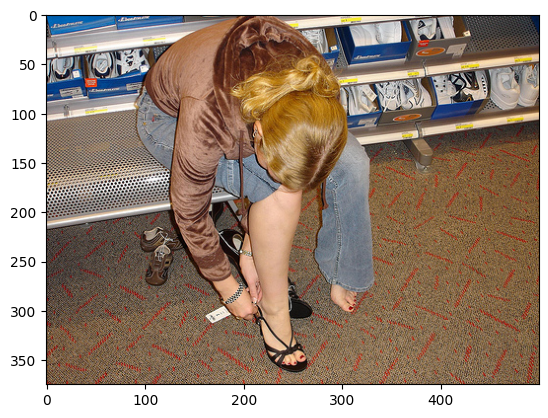

In [48]:
generate_caption(1, unq_valid_imgs.iloc[5]['image_name'])

Actual Caption : 
[' A small boy in sandals sits on a wooden post in a field .', ' A boy sits on the tall fence post and smiles .', ' A child sits on top of a large tree stump .', ' A boy sits on a tree stump .', ' A boy sitting on a stump .']


Predicted caption : 
man with backpack on is holding an acoustic air .


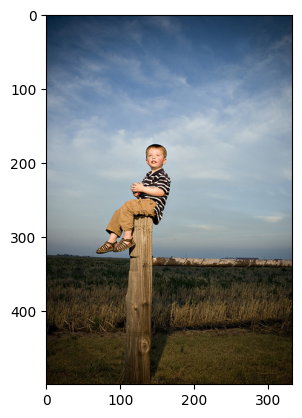

In [49]:
generate_caption(2, unq_valid_imgs.iloc[500]['image_name'])

### 2nd Example

Actual Caption : 
[' A soccer net at sunset .', ' A man playing ball at sunset .', ' A man tosses a soccer ball in the air on the beach at sunset while boats go by in the distance .', ' A silhouette of a man about to hit a volleyball on the beach at sunset .', ' A person is playing a game with a ball as the sun sets by the water .']


Predicted caption : 
two men are playing on bridge .


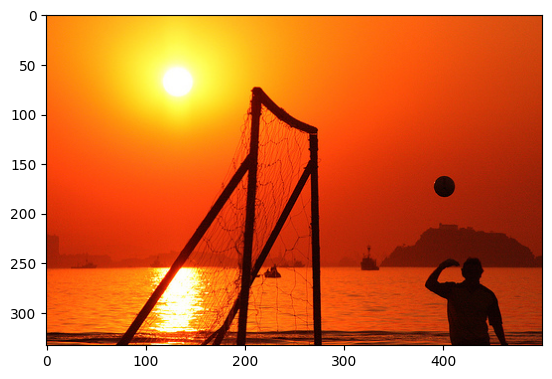

In [50]:
generate_caption(1, unq_valid_imgs.iloc[100]['image_name'])

Actual Caption : 
[' A soccer net at sunset .', ' A man playing ball at sunset .', ' A man tosses a soccer ball in the air on the beach at sunset while boats go by in the distance .', ' A silhouette of a man about to hit a volleyball on the beach at sunset .', ' A person is playing a game with a ball as the sun sets by the water .']


Predicted caption : 
two men are on bridge .


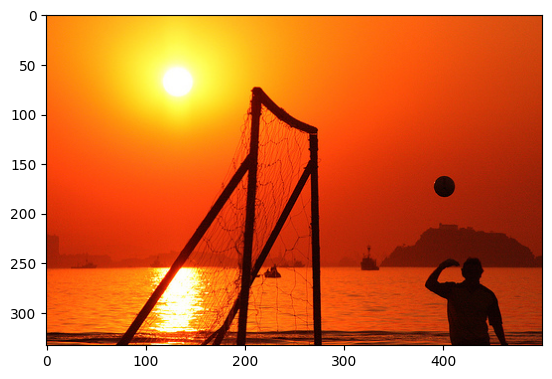

In [51]:
generate_caption(2, unq_valid_imgs.iloc[100]['image_name'])

### 3rd Example

Actual Caption : 
[' Four women are sitting against a home while a woman in a white skirt walks away .', ' Women in African garb sit outside while one in Western wear walks past .', ' Several women in brightly patterned skirts sit by a stone wall .', ' A woman in a light green skirt is holding a black purse .', ' Five African women talking .']


Predicted caption : 
man with black hair and white striped shirt with yellow safety yellow safety vests .


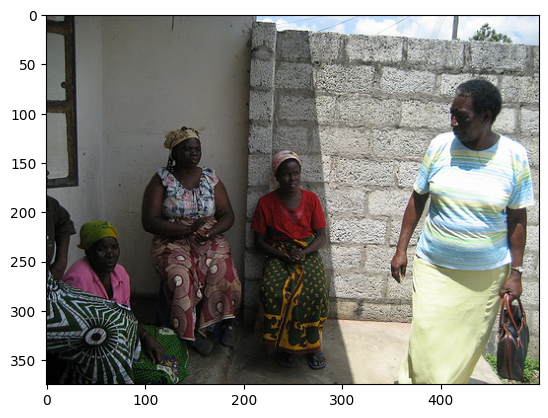

In [52]:
generate_caption(1, unq_valid_imgs.iloc[15]['image_name'])

Actual Caption : 
[' Four women are sitting against a home while a woman in a white skirt walks away .', ' Women in African garb sit outside while one in Western wear walks past .', ' Several women in brightly patterned skirts sit by a stone wall .', ' A woman in a light green skirt is holding a black purse .', ' Five African women talking .']


Predicted caption : 
man with black shirt and white shirt standing on top of large green wall .


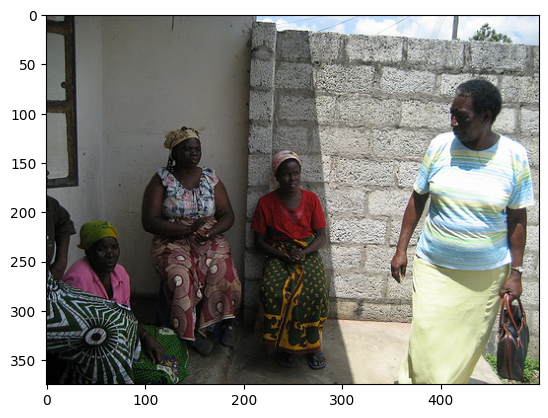

In [53]:
generate_caption(2, unq_valid_imgs.iloc[15]['image_name'])

### 4rth Example

Actual Caption : 
[' Young , female child , playing with a balloon .', ' A girl in a pink shirt playing with a green ball .', ' A girl in a pink shirt looking at a green balloon .', ' A young brown-haired girl is playing with a large green balloon in a cave .', ' A young girl in a pink shirt stretching to touch a green balloon .']


Predicted caption : 
two children playing with large ball .


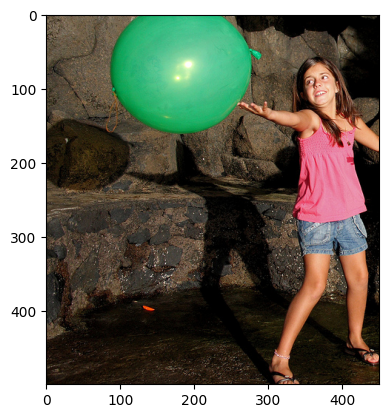

In [54]:
generate_caption(1, unq_valid_imgs.iloc[600]['image_name'])

Actual Caption : 
[' Young , female child , playing with a balloon .', ' A girl in a pink shirt playing with a green ball .', ' A girl in a pink shirt looking at a green balloon .', ' A young brown-haired girl is playing with a large green balloon in a cave .', ' A young girl in a pink shirt stretching to touch a green balloon .']


Predicted caption : 
girl in pink dress playing with large balloon on it .


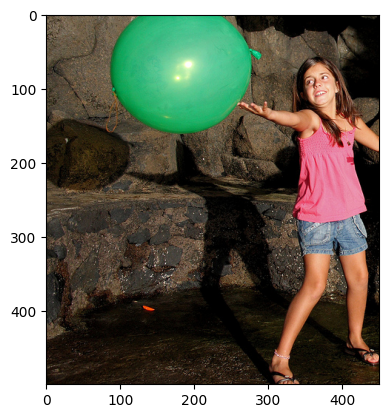

In [55]:
generate_caption(2, unq_valid_imgs.iloc[600]['image_name'])